# Recovery of Heard Speech Spectrograms

## Getting the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from algorithms import *
from utils import *
%load_ext autoreload
%autoreload 2

In [6]:
X_full = getX(1, 'MS01')
print('X found')
Y = getY(1, 'MS01')
print('Y found')
A = getA(1, 'MS01', lam=1)
print('A found')

X found
Y found
A found


In [7]:
print(X_full.shape, Y.shape, A.shape)

(2304, 5624) (64, 5624) (64, 2304)


In [8]:
np.linalg.norm(Y-A@X_full, 'fro')/np.prod(Y.shape)

0.0015720156379853663

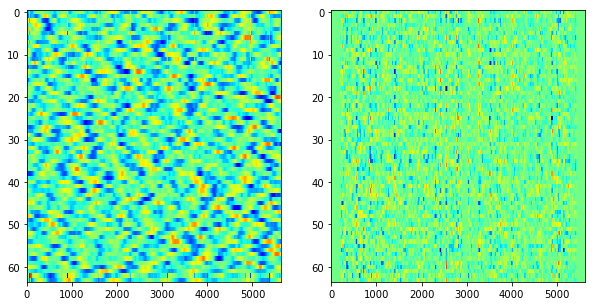

In [9]:
# %matplotlib qt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(saturate(Y), aspect='auto',cmap='jet')
plt.subplot(122)
plt.imshow(saturate(A@X_full), aspect='auto',cmap='jet')
plt.show()

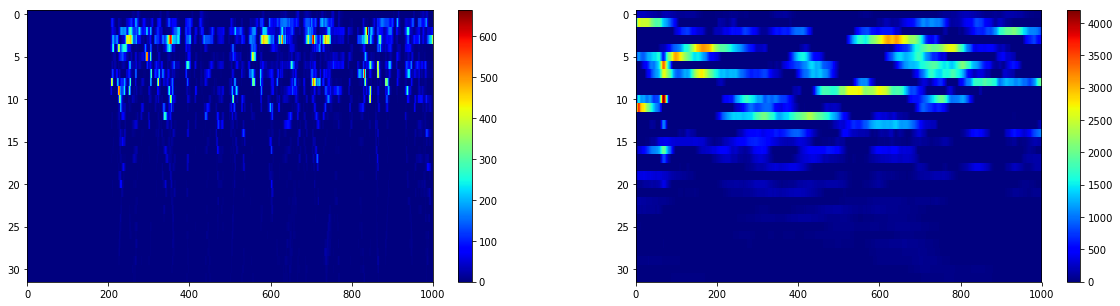

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(X_full[:32,:1000], aspect='auto',cmap='jet')
plt.colorbar()
plt.subplot(122)
rec = np.linalg.pinv(A)@Y
rec[rec<0] = 0
plt.imshow(rec[:32,:1000], aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

## Sparse Recovery and tuning for single time step

In [11]:
X = X_full[:,200:-200]
Y_new = A@X

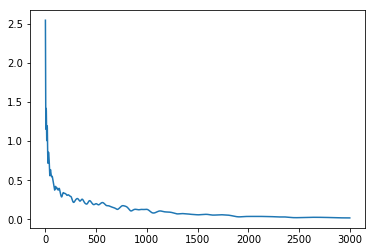

Error in objective (sparse) :  0.02005221876305095
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  1282.238537910856
Error in x (dense) :  1582.2624265796742


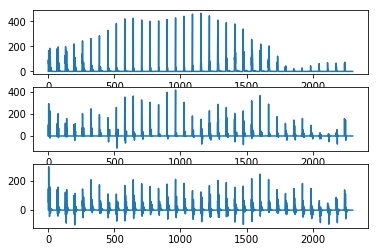

In [8]:
u = 1000
alpha = 1.2
lamda = 1e-1
t = 400
x,v,err = ALM(A,Y_new[:,t],u,alpha,lamda,iters=3000)
show_result_single(A,Y_new,X,x,err,t)

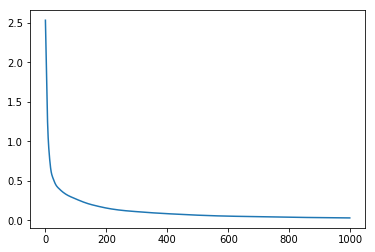

Error in objective (sparse) :  0.02997759159056288
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  1649.8238474461423
Error in x (dense) :  1582.2624265796742


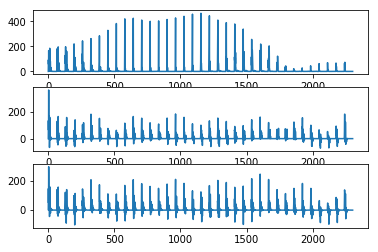

In [9]:
eig,_ = np.linalg.eig(np.dot(A.T,A))
alpha = 1/np.max(np.real(eig))
beta = 1
lamda = 1e-7
x,err = acc_prox_grad(A,Y_new[:,t],alpha,beta,lamda,iters=1000)
show_result_single(A,Y_new,X,x,err,t)

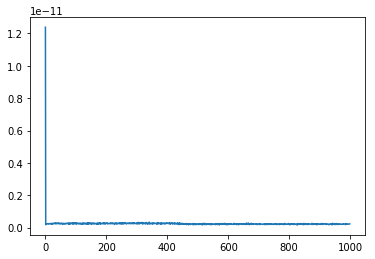

Error in objective (sparse) :  2.3280022703417345e-13
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  1281.8313736617426
Error in x (dense) :  1582.2624265796742


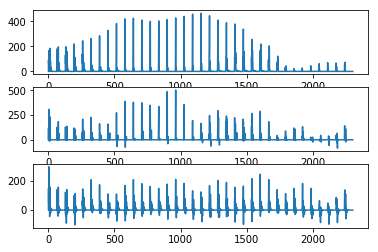

In [10]:
lr = 4e-1
x,err = proj_subgrad(A,Y_new[:,t],lr,iters=1000)
show_result_single(A,Y_new,X,x,err,t)

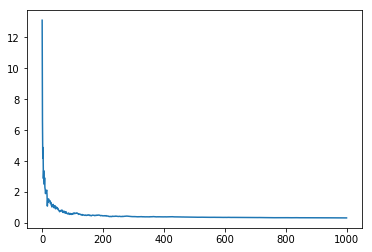

Error in objective (sparse) :  0.33396952389531626
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  2267.6928349859418
Error in x (dense) :  1582.2624265796742


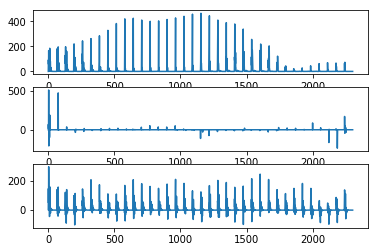

In [11]:
tau = 4000
x,v,err = FrankWolfe(A,Y_new[:,t],tau,iters=1000)
show_result_single(A,Y_new,X,x,err,t)

## All time steps

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0



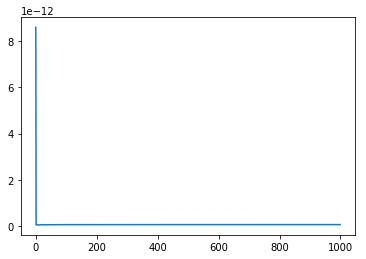

Error in objective (sparse) :  5.3267498873853517e-14
Error in objective (dense) :  7.090865028943357e-13
Error in X (sparse) :  76157.6714470609
Error in X (dense) :  78906.56910223544


In [29]:
from tqdm import tqdm_notebook as tqdm
# Using projected subgradient method
lr = 1e-1
X_rec = np.zeros_like(X)
iters = 1000
err = np.zeros(iters)
t = np.shape(Y_new)[1]

for i in tqdm(range(t)):
    X_rec[:,i],temp = proj_subgrad(A,Y_new[:,i],lr,iters=iters)
    err += np.array(temp)/t
    
show_result(A,Y_new,X,X_rec,err)

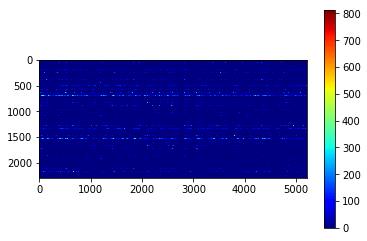

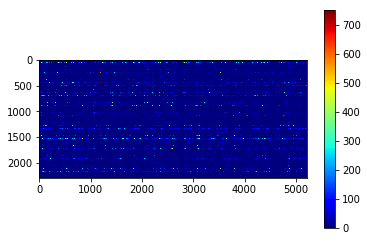

In [30]:
X_reca = X_rec.copy()
X_reca[X_reca<0] = 0
plt.imshow(X_reca,cmap='jet')
plt.colorbar()
plt.show()
plt.imshow(X,cmap='jet')
plt.colorbar()
np.save('X_rec.npy',X_reca)

In [3]:
# Load result from saved file
X_rec = np.load('X_rec.npy')
X_rec.shape

(2304, 5224)

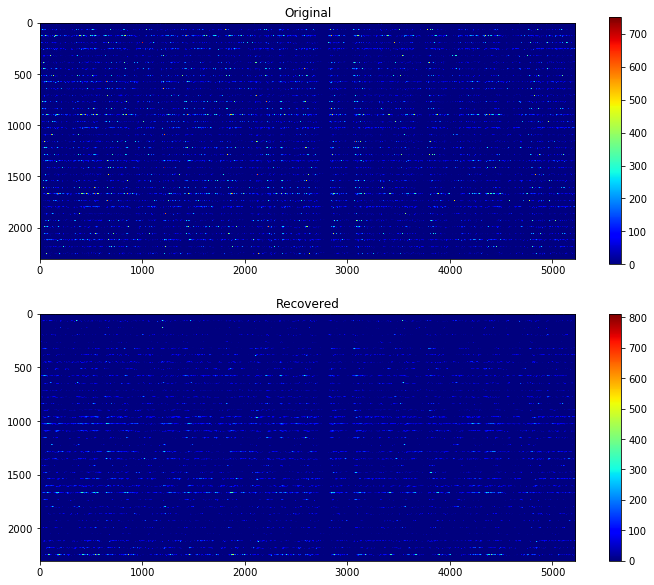

In [14]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.title('Original')
plt.imshow(X,cmap='jet', aspect='auto')
plt.colorbar()
plt.subplot(212)
plt.title('Recovered')
plt.imshow(X_rec, cmap='jet', aspect='auto')
plt.colorbar()
plt.show()

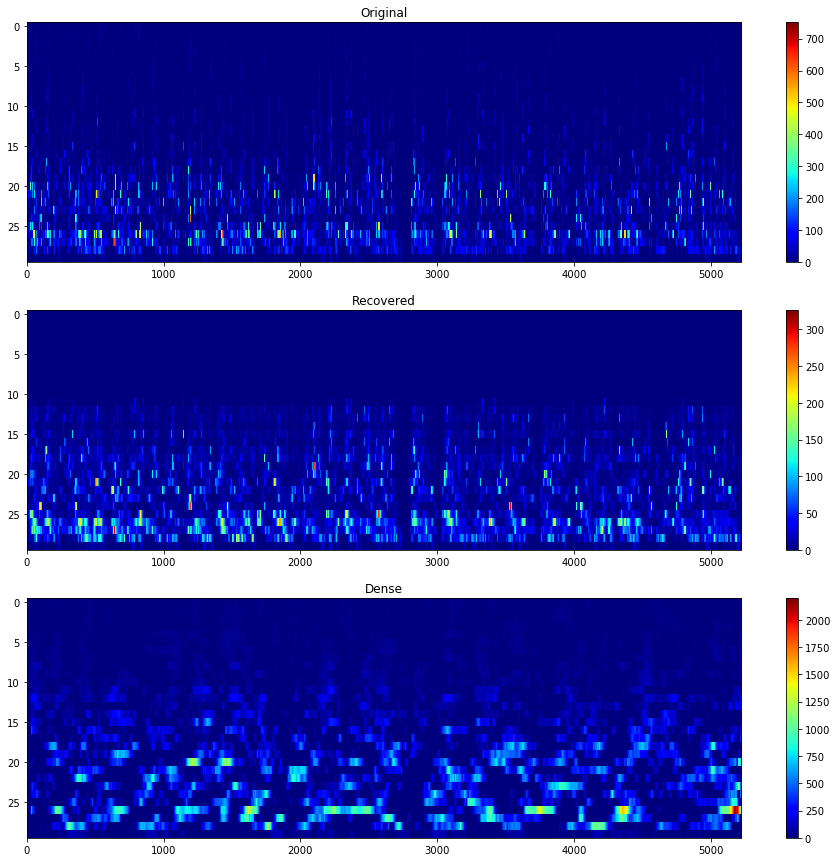

Rec Fro Loss 9748.021451328605
Dense Fro Loss 73845.64911699039


In [31]:
X0rec = delagData(X_rec.T, mode='mean')
X0rec = X0rec.T
X0 = delagData(X.T)
X0 = X0.T
X0dense = np.linalg.pinv(A) @ Y[:,200:-200]
X0dense = delagData(X0dense.T, mode='median')
X0dense = X0dense.T
X0dense[X0dense<0] = 0

plt.figure(figsize=(16,15))
plt.subplot(311)
plt.title('Original')
plt.imshow(np.flipud(X0[:30,:]),cmap='jet', aspect='auto')
plt.colorbar()
plt.subplot(312)
plt.title('Recovered')
plt.imshow(np.flipud(X0rec[:30,:]), cmap='jet', aspect='auto')
plt.colorbar()
plt.subplot(313)
plt.title('Dense')
plt.imshow(np.flipud(X0dense[:30,:]), cmap='jet', aspect='auto')
plt.colorbar()
plt.show()

print('Rec Fro Loss', np.linalg.norm(X0-X0rec, 'fro'))
print('Dense Fro Loss', np.linalg.norm(X0-X0dense, 'fro'))